In [153]:
import json
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import re
#from sklearn.feature_selection import mutual_info_classif
#from sklearn.decomposition import LatentDirichletAllocation
from sklearn import metrics

In [154]:
# Read Health dataset to fetch Reviews and Description.
dataset_health = json.load(open('reviews_Health_and_Personal_Care_5_Health & Personal Care_clean.json'))

# Read Food dataset to fetch Reviews and Description.
dataset_food = json.load(open('reviews_Grocery_and_Gourmet_Food_5_Grocery & Gourmet Food_clean.json'))

# Read Beauty dataset to fetch Reviews and Description.
dataset_beauty = json.load(open('reviews_Beauty_5_Beauty_clean.json'))

In [155]:
# Read processed classification dataset to fetch the target variable.
classification_df = pd.read_csv('final_classification_dataset.csv')
classification_dict = {}
for i,r in classification_df.iterrows():
    classification_dict[r["ASIN"]] = r["class"]

In [156]:
# Merge Reviews and Description with class (target) for category Health.
dataset_health = json.load(open('./data/reviews_Health_and_Personal_Care_5.ujson'))
final_dict = {}
for asin in dataset_health:
    if asin in classification_dict:
        final_dict[asin] = {
            "review" : dataset_health[asin]["Best review"],
            "description" : dataset_health[asin]["description"],
            "class" : classification_dict[asin]
        }

In [157]:
# Merge Reviews and Description with class (target) for category Food.
dataset_food = json.load(open('./data/reviews_Grocery_and_Gourmet_Food_5.ujson'))
#final_dict = {}
for asin in dataset_food:
    if asin in classification_dict:
        final_dict[asin] = {
            "review" : dataset_food[asin]["Best review"],
            "description" : dataset_food[asin]["description"],
            "class" : classification_dict[asin]
        }

In [158]:
# Merge Reviews and Description with class (target) for category Beauty.
dataset_beauty = json.load(open('./data/reviews_Beauty_5.ujson'))
#final_dict = {}
for asin in dataset_beauty:
    if asin in classification_dict:
        final_dict[asin] = {
            "review" : dataset_beauty[asin]["Best review"],
            "description" : dataset_beauty[asin]["description"],
            "class" : classification_dict[asin]
        }

In [159]:
# Clean and merge Reviews/Descriptions/Class for all categories.
regex = re.compile('[^a-zA-Z\s]')
review_corpus = []
description_corpus = []
corpus = []
sales_data = []
target = []
for asin in final_dict:
    best_review = regex.sub('', final_dict[asin]["review"])
    #best_review = all_json[asin]["Best review"]
    review_corpus.append(best_review)
    #corpus.append(best_review)
    description = regex.sub('', final_dict[asin]["description"])
    description_corpus.append(description)
    corpus.append(best_review + description)
    target.append(final_dict[asin]["class"])

In [160]:
# Split the entire corpus into test and train datasets.
from sklearn.model_selection import train_test_split
# Change 'corpus' with individual product category datasets to run the code at category level.
X_train, X_test, y_train, y_test = train_test_split(corpus, target, test_size=0.25,random_state=1)

In [161]:
# Initialize count vectorizer to convert text into vector.
# Since 1-gram was not giving good results we've used ngram_range as (2,3) for bi-grams and tri-grams.
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(stop_words='english',analyzer='word',ngram_range=(2,3),token_pattern=r'\w{1,}')#,max_features=20, token_pattern=r'\w{1,}'
count_vect = vect.fit_transform(X_train)

#print(vect.get_feature_names())
#print()
#print(vect.vocabulary_)
#print(review_count_vect.shape)
#print(type(review_count_vect))
#print(review_count_vect.toarray())

In [162]:
# Convert the count vector into frequency matrix.
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer(use_idf=True,norm='l2',smooth_idf=True)
tfidf = transformer.fit_transform(count_vect)
#print(transformer.fit_transform(review_count_vect).toarray())
#print(tfidf.shape)
#print(tfidf.toarray())

In [163]:
#Store feature names. This is required to map Logistic Registic Regression coefficients with feature names.
features = vect.get_feature_names()
#print(features)

In [164]:
# Run Logistic Regression on the entire feature set.
from sklearn.linear_model import LogisticRegressionCV

regr = LogisticRegressionCV(cv=10)
regr.fit(tfidf,y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [165]:
# Top 10 feature selection.
feature_cols = []
for col in features:
    if col != 'class':
        feature_cols.append(col)

# pair the feature names with the coefficients
nameCoefDict = {}
for f,c in zip(feature_cols,list(regr.coef_[0])):
    #print(f," : ",c)
    nameCoefDict[f] = c

from collections import OrderedDict
d_sorted_by_value = OrderedDict(sorted(nameCoefDict.items(), key=lambda x: x[1]))
good_features = []
for k, v in d_sorted_by_value.items():
    if v > 0.5:
        good_features.append(k)

for f in good_features:
    print(f,d_sorted_by_value[f])
len(good_features)

bone density 0.500654172235
helps remove 0.50074404105
personal lubricant 0.502740273777
free products 0.502786253912
philips sonicare 0.502895951851
digital bathroom 0.505136725854
does leave 0.506544488876
treat cure 0.506761904841
use twice 0.50857701726
fine lines wrinkles 0.510002736727
youll love 0.510197204478
immune function 0.513538452804
face body 0.513866855301
animals usa 0.514528305569
pike place 0.516984400023
external use 0.519678188687
low carb 0.520233672786
dirt oil 0.520332470725
extra virgin 0.520369993063
natural product 0.522637402088
times daily 0.52397655601
test strip 0.524178410116
red bull 0.527304233381
contains sugar 0.529207285095
naturally occurring 0.530011363539
dry hair 0.53184838424
cherry juice 0.533197458674
cardiovascular health 0.533226218757
muscle mass 0.535766301938
help reduce 0.535933294828
mg daily 0.536074909223
dietary supplement 0.538111220589
salt products 0.538186173094
like hair 0.538303692684
gently cleanses 0.538717181816
kirkland si

184

In [166]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(tfidf, y_train)

In [167]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB())])
text_clf = text_clf.fit(X_train, y_train)

In [170]:
import numpy as np
predicted = text_clf.predict(X_test)
print("Accuracy: ",np.mean(predicted == y_test))
print("Confusion Matrix: ",metrics.confusion_matrix(y_test,predicted))

Accuracy:  0.606965174129
Confusion Matrix:  [[924 586]
 [599 906]]


In [171]:
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=1e-3, n_iter=5, random_state=42))
])
_ = text_clf_svm.fit(X_train, y_train)
predicted_svm = text_clf_svm.predict(X_test)
print("Accuracy: ",np.mean(predicted_svm == y_test))
print("Confusion Matrix: ",metrics.confusion_matrix(y_test,predicted_svm))

C:\Users\Aparna\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Accuracy:  0.593698175788
Confusion Matrix:  [[849 661]
 [564 941]]


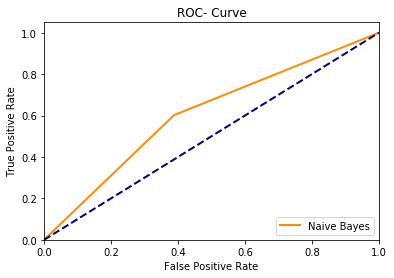

In [173]:
#Merge ROC Curve for each Classifier.
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

n_classes = 2 #y.shape[1]
fpr, tpr, _ = roc_curve(y_test, predicted)
fpr_2, tpr_2, _ = roc_curve(y_test, predicted_svm)
roc_auc = auc(fpr, tpr)

# Compute micro-average ROC curve and ROC area
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='Naive Bayes' % roc_auc)#ROC curve (area = %0.2f) - 

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC- Curve')
plt.legend(loc="lower right")
plt.show()